In [1]:
import pandas as pd 
import numpy as np 
import xgboost as xgb
import matplotlib.pyplot as plt  
from numpy import mean 
from numpy import sort 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import preprocessing 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier 
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from xgboost import plot_importance
from xgboost import cv 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel 
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from matplotlib import pyplot
from imblearn.over_sampling import SMOTE
import shap

In [2]:
dtype = {
    'AGE_NEONATE': int,
    'AWEEKEND': int,
    'DIED': int,
    'ELECTIVE': int,
    'FEMALE': int,
    'HOSPBRTH': int,
    'NEOMAT': int,
    'ORPROC': int,
    'HCUP_ED': int,
    'Cancer': int,
    'Cardio_Circulatory': int,
    'Pneumo': int,
    'Gastro': int,
    'Renal': int,
    'Genital': int,
    'Pregnancy': int,
    'Bones_Joints_Chronic': int,
    'Congenital': int,
    'Myoskeletal_Acute': int,
    'Emergency': int,
    'NIS_STRATUM': int,
    'ZIPINC_QRTL': int,
    'PAY1': int,
    'PL_NCHS': int,
    'RACE': int,
    'TRAN_IN': int,
    'TRAN_OUT': int,
    'AMONTH': int,
    'HOSP_DIVISION': int,
    'HOSP_NIS': int,
    'AGE': float,
    'LOS': float,
    'NCHRONIC': float,
    'NDX': float,
    'NECODE': float,
    'NPR': float,
    'TOTCHG': float,
    }

In [3]:
df=pd.read_csv('NIS 2013XGBoost_withoutNaN.csv', delimiter=';', na_values=' ')
df.drop('DISPUNIFORM', axis=1, inplace = True)
df.drop('KEY_NIS', axis=1, inplace = True)
df.dropna(inplace=True)
for k, v in dtype.items():
    df[k] = df[k].astype(v)

In [4]:
df.columns = df.columns.str.strip()

In [5]:
df.shape

(632908, 37)

In [6]:
value_distribution = df['DIED'].value_counts()
value_distribution

0    620800
1     12108
Name: DIED, dtype: int64

In [7]:
df['y'] = df['DIED']


In [8]:
print(df.columns)


Index(['AGE', 'AGE_NEONATE', 'AMONTH', 'AWEEKEND', 'DIED', 'ELECTIVE',
       'FEMALE', 'HCUP_ED', 'HOSPBRTH', 'HOSP_DIVISION', 'HOSP_NIS', 'LOS',
       'NCHRONIC', 'NDX', 'NECODE', 'NEOMAT', 'NIS_STRATUM', 'NPR', 'ORPROC',
       'PAY1', 'PL_NCHS', 'RACE', 'TOTCHG', 'TRAN_IN', 'TRAN_OUT',
       'ZIPINC_QRTL', 'Cancer', 'Cardio_Circulatory', 'Pneumo', 'Gastro',
       'Renal', 'Genital', 'Pregnancy', 'Bones_Joints_Chronic', 'Congenital',
       'Myoskeletal_Acute', 'Emergency', 'y'],
      dtype='object')


In [9]:
#df['DIED'] = pd.to_numeric(df['DIED'], errors='coerce').fillna(0).astype('Int64')
df.dropna(subset=['DIED'], inplace=True)
#df['DIED'] = df['DIED'].astype('int64')

In [10]:
# Set pandas options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Display the DataFrame with full information
print("Columns and Data Types:")
print(df.dtypes)

Columns and Data Types:
AGE                     float64
AGE_NEONATE               int32
AMONTH                    int32
AWEEKEND                  int32
DIED                      int32
ELECTIVE                  int32
FEMALE                    int32
HCUP_ED                   int32
HOSPBRTH                  int32
HOSP_DIVISION             int32
HOSP_NIS                  int32
LOS                     float64
NCHRONIC                float64
NDX                     float64
NECODE                  float64
NEOMAT                    int32
NIS_STRATUM               int32
NPR                     float64
ORPROC                    int32
PAY1                      int32
PL_NCHS                   int32
RACE                      int32
TOTCHG                  float64
TRAN_IN                   int32
TRAN_OUT                  int32
ZIPINC_QRTL               int32
Cancer                    int32
Cardio_Circulatory        int32
Pneumo                    int32
Gastro                    int32
Renal           

In [11]:
#chech distribution of some collumns, eg AGE seems to have zero and omicron (thats why it cannot be converted into numeric)
value_distribution = df['DIED'].value_counts()
df0 = df[df['DIED'] == 0]
df1 = df[df['DIED'] == 1]
df0 = df0.sample(n=df1.shape[0], random_state=0)
df = df0.append(df1)
df.shape

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(24216, 38)

In [12]:
df['y'] = df['DIED']

In [13]:
df = df.drop(columns=['TOTCHG', 'DIED'])
df = df.select_dtypes(exclude=['object', 'category'])
X, y = df.drop('y', axis=1), df['y']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [15]:
y_train.dtypes

dtype('int32')

In [16]:
X_train.dtypes

AGE                     float64
AGE_NEONATE               int32
AMONTH                    int32
AWEEKEND                  int32
ELECTIVE                  int32
FEMALE                    int32
HCUP_ED                   int32
HOSPBRTH                  int32
HOSP_DIVISION             int32
HOSP_NIS                  int32
LOS                     float64
NCHRONIC                float64
NDX                     float64
NECODE                  float64
NEOMAT                    int32
NIS_STRATUM               int32
NPR                     float64
ORPROC                    int32
PAY1                      int32
PL_NCHS                   int32
RACE                      int32
TRAN_IN                   int32
TRAN_OUT                  int32
ZIPINC_QRTL               int32
Cancer                    int32
Cardio_Circulatory        int32
Pneumo                    int32
Gastro                    int32
Renal                     int32
Genital                   int32
Pregnancy                 int32
Bones_Jo

In [17]:
paramGrid = { 
    "learning_rate": [0.05], 
    "n_estimators": [400], 
    "max_depth": [6],  
    'subsample': [0.8], 
    "colsample_bylevel": [0.8],
    "colsample_bytree": [0.8],
    'gamma': [0.2]
}

In [18]:
model = XGBClassifier(objective="binary:logistic", use_label_encoder=False, random_state=42) 
cv = KFold(n_splits=5, shuffle=True)


In [19]:
gridsearch = GridSearchCV(model, paramGrid, scoring='roc_auc', cv=cv, verbose=2) 
fit = gridsearch.fit(X_train, y_train) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bylevel=0.8, colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.8; total time=   8.6s
[CV] END colsample_bylevel=0.8, colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.8; total time=   6.4s
[CV] END colsample_bylevel=0.8, colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.8; total time=   9.4s
[CV] END colsample_bylevel=0.8, colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.8; total time=   5.8s
[CV] END colsample_bylevel=0.8, colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.8; total time=   9.8s


In [20]:
print("Best ROC AUC score:", fit.best_score_)
print("Best parameters:", fit.best_params_)

Best ROC AUC score: 0.9536518893207679
Best parameters: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 400, 'subsample': 0.8}


In [21]:
best_model = fit.best_estimator_

y_pred = best_model.predict(X_test)

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [22]:
print(f'F1 Score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

F1 Score: 0.8834
ROC-AUC: 0.8823
Accuracy: 0.8819
Precision: 0.8605
Recall: 0.9075


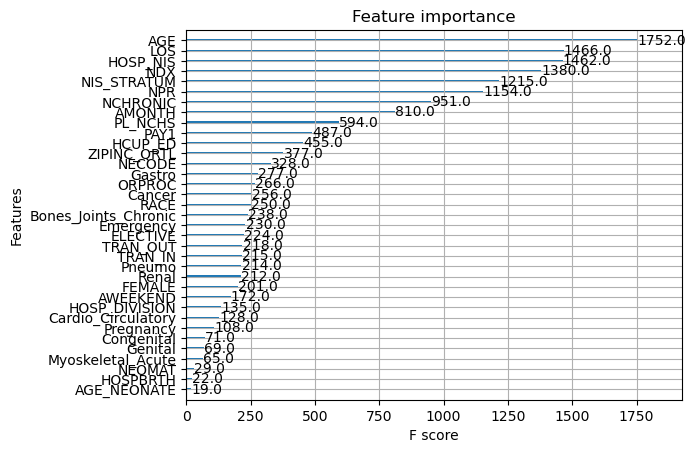

In [23]:
xgb.plot_importance(best_model)
plt.show()

In [24]:
explainer = shap.TreeExplainer(best_model)

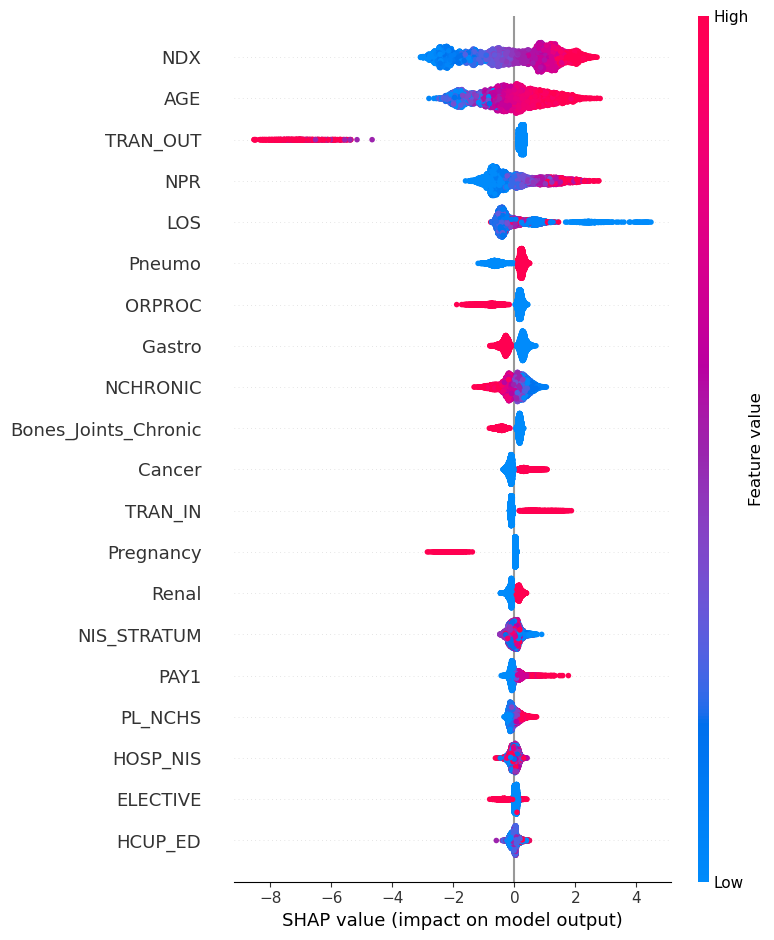

In [25]:
shap_values = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test)


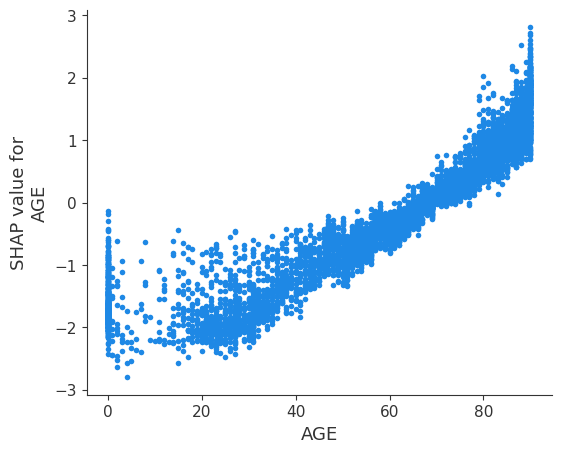

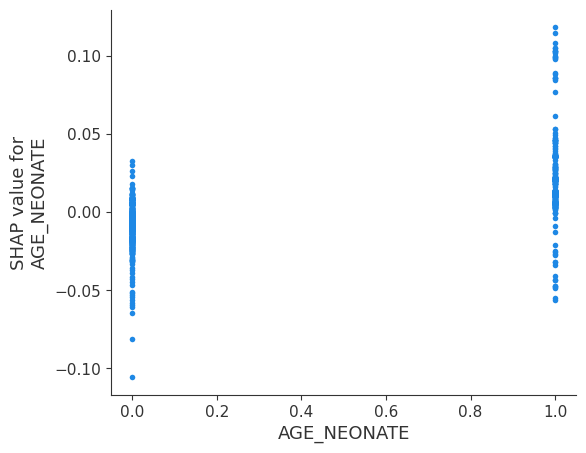

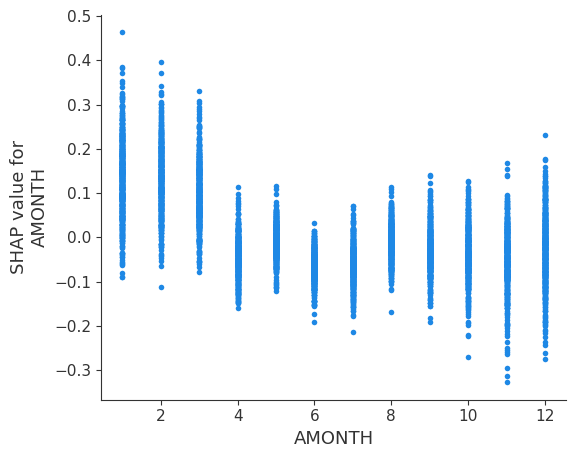

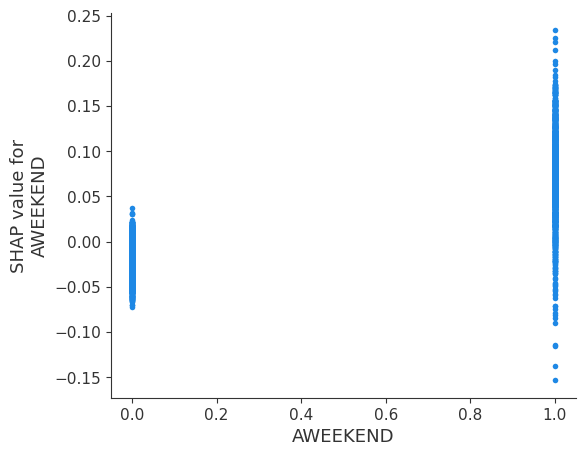

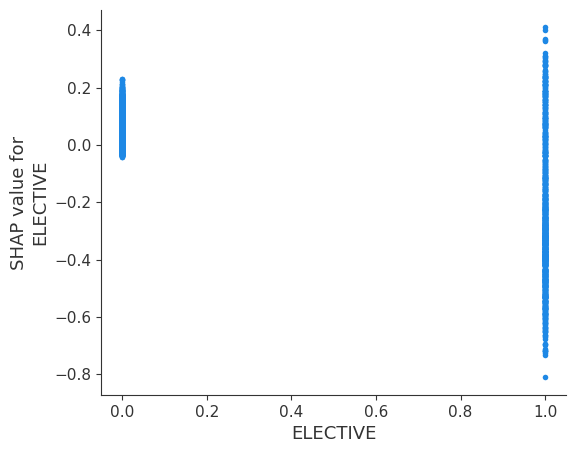

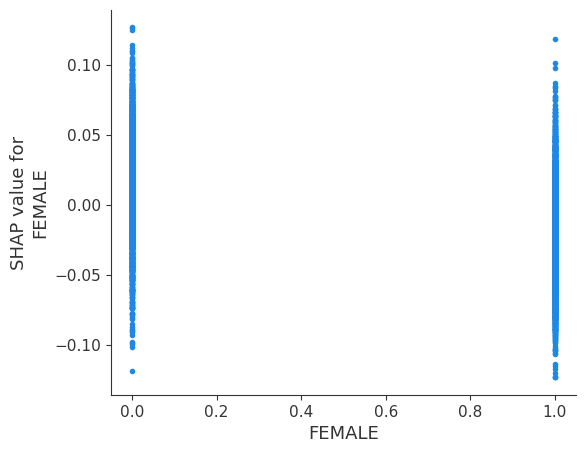

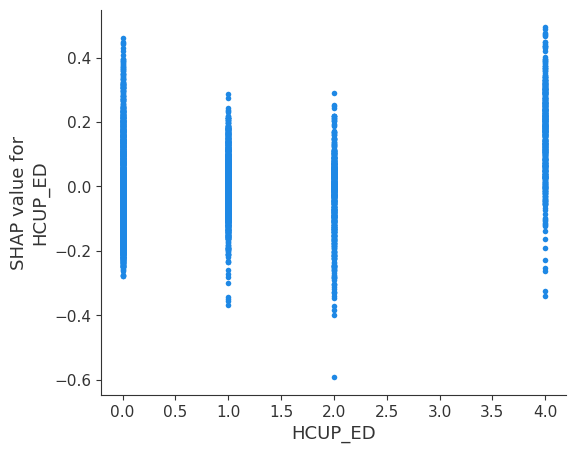

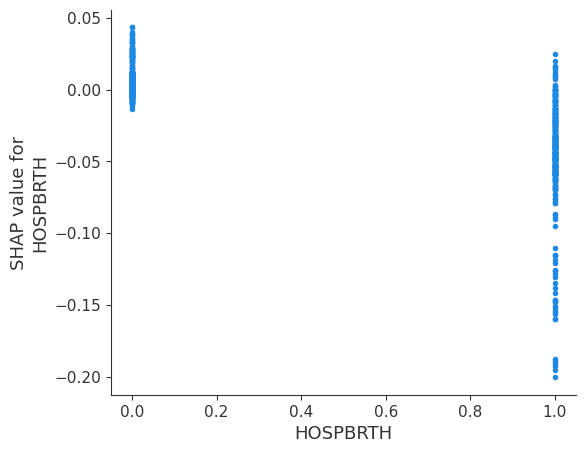

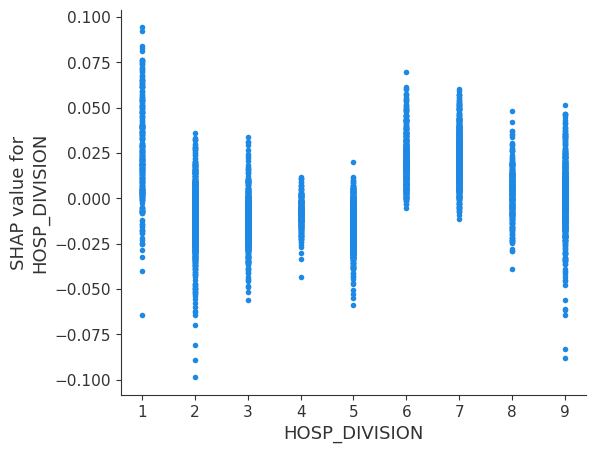

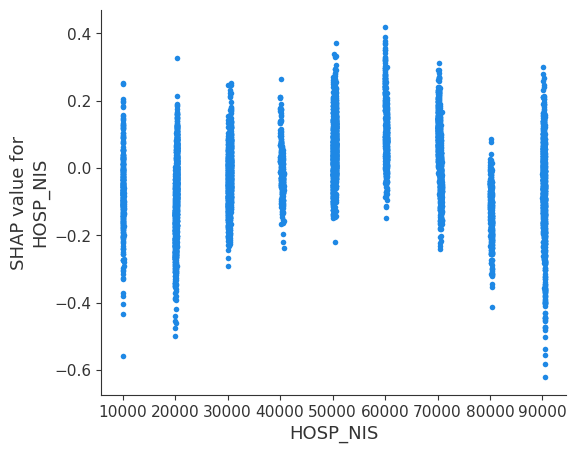

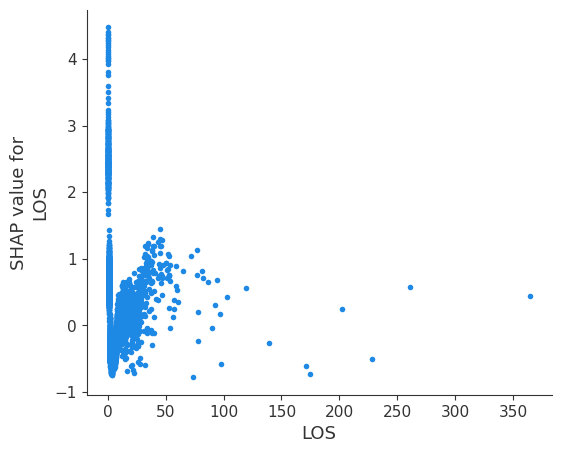

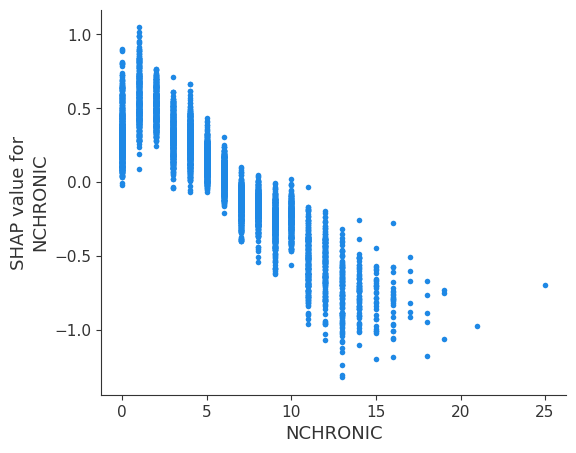

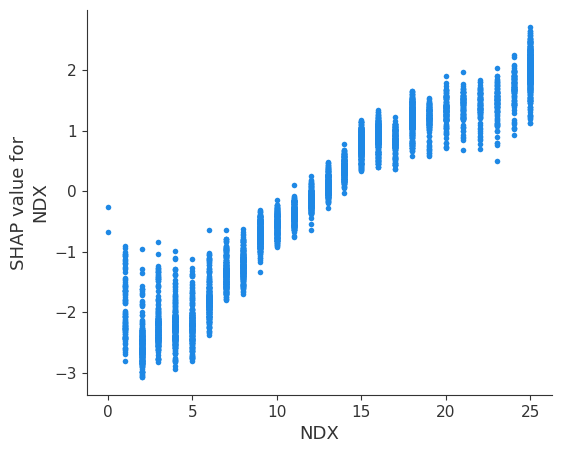

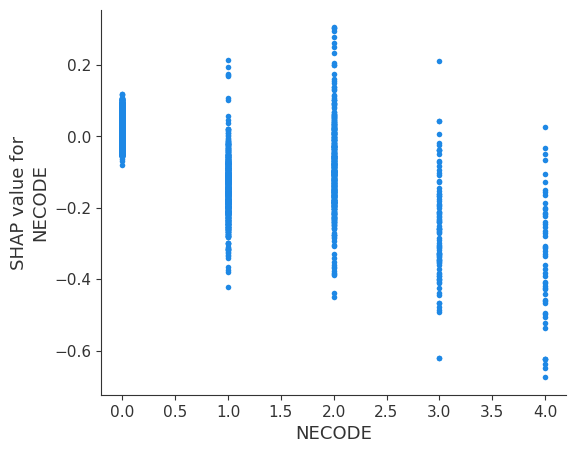

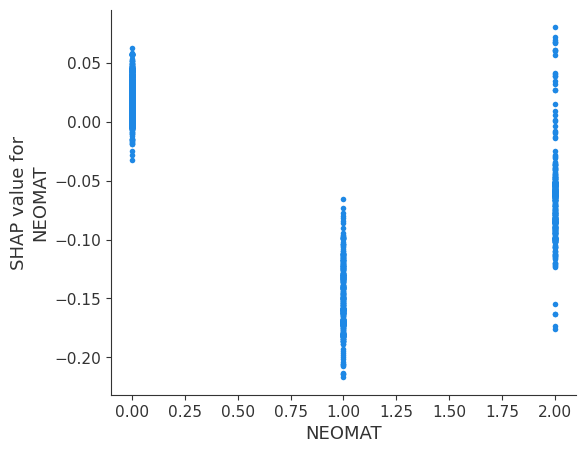

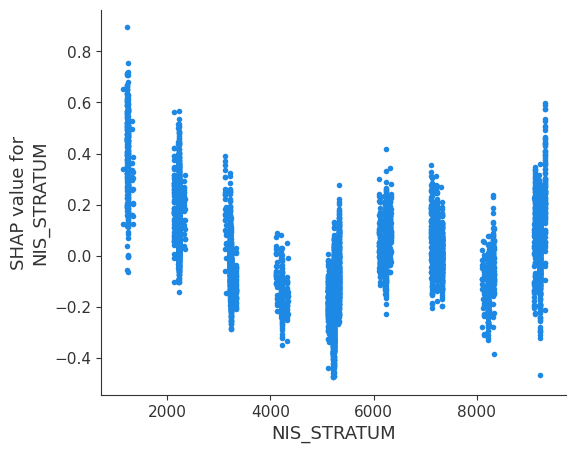

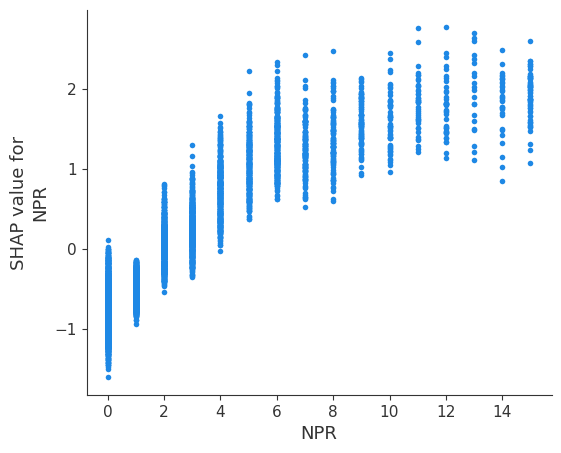

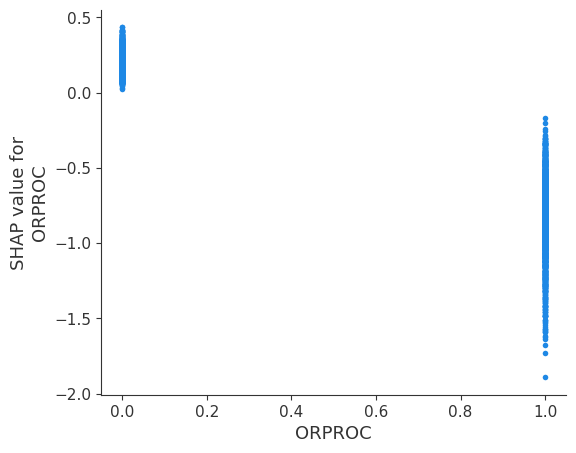

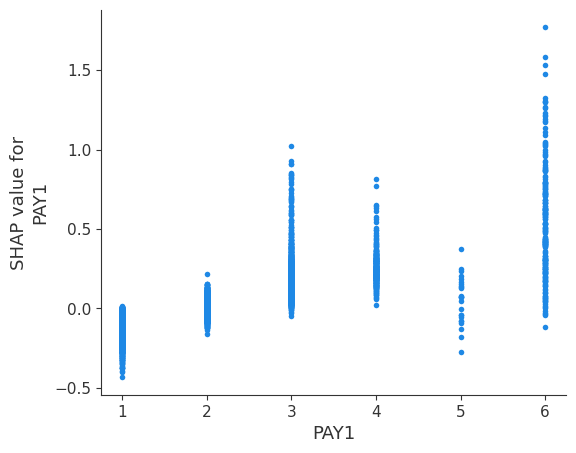

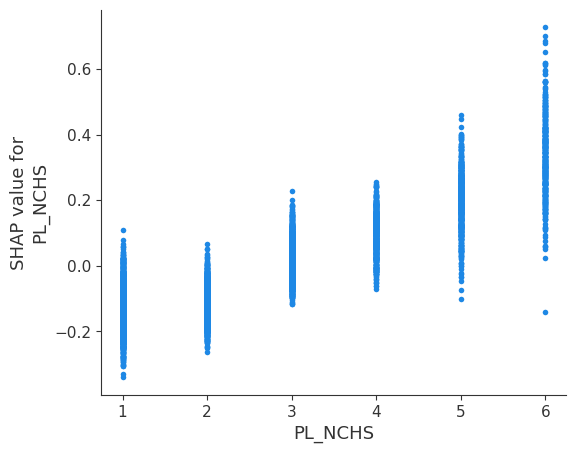

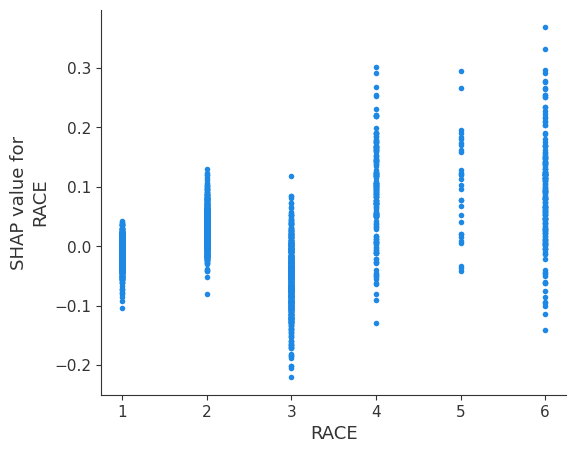

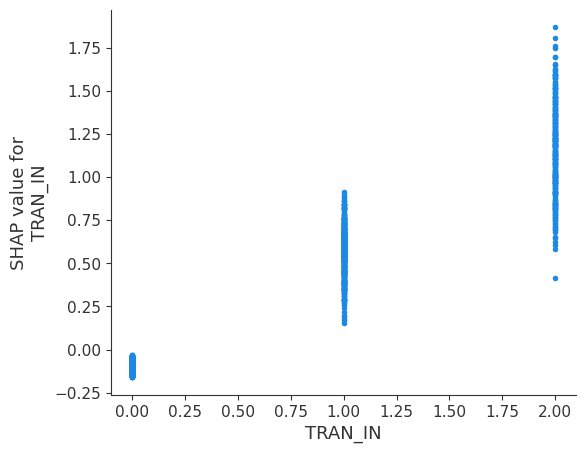

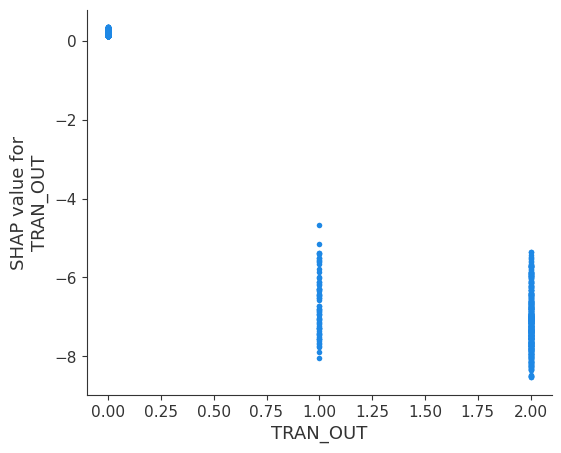

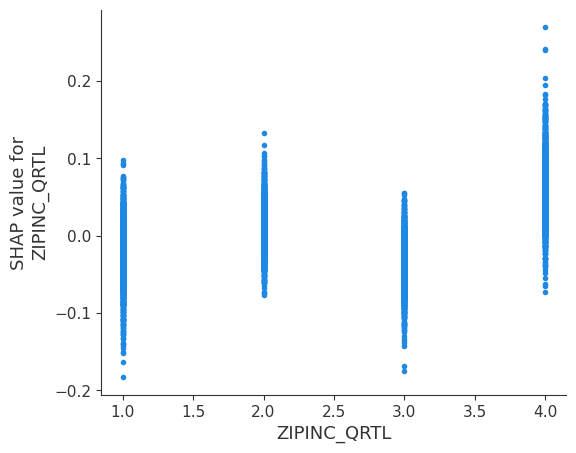

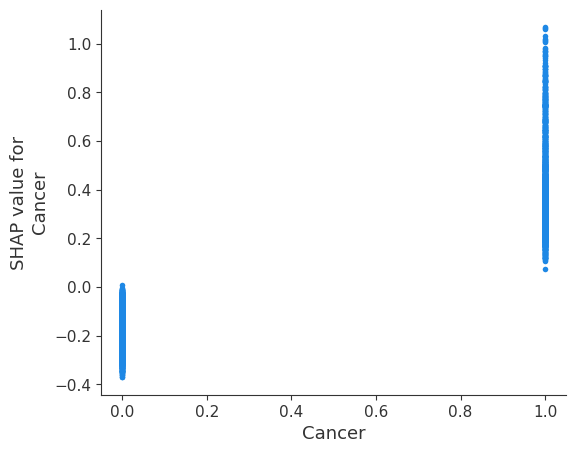

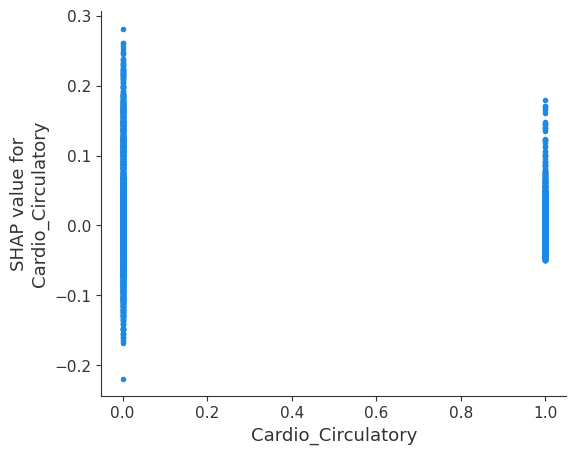

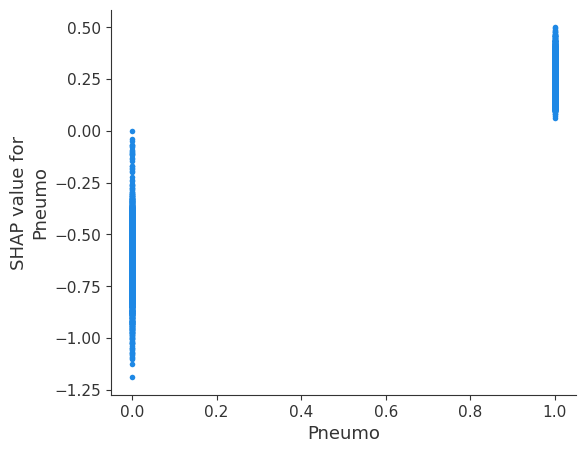

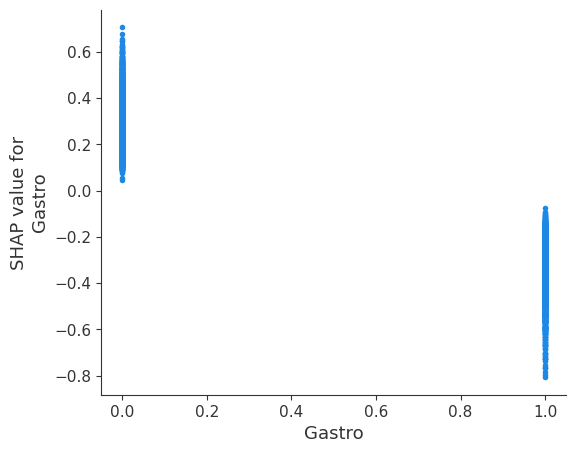

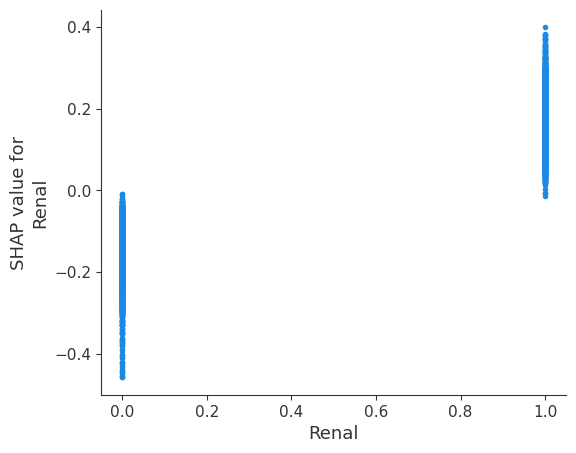

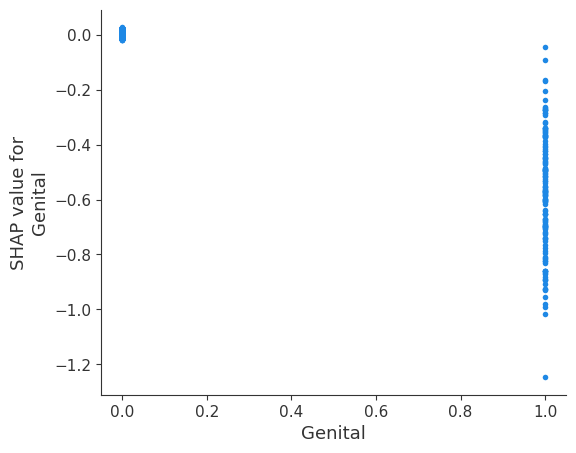

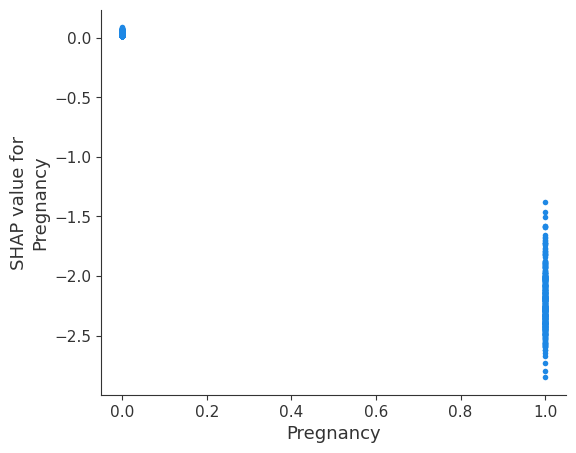

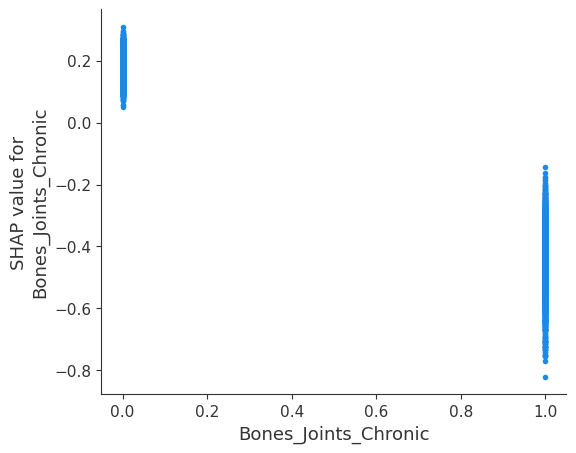

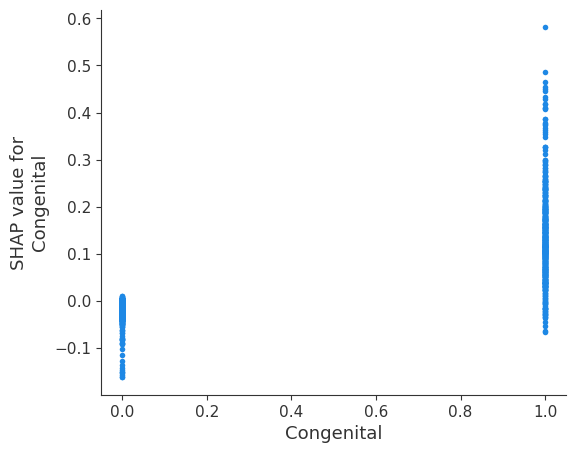

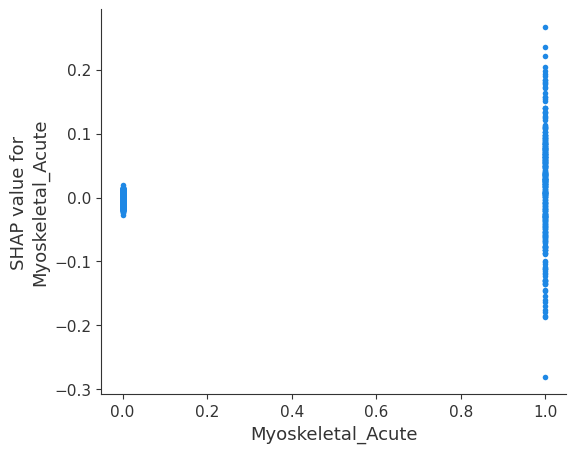

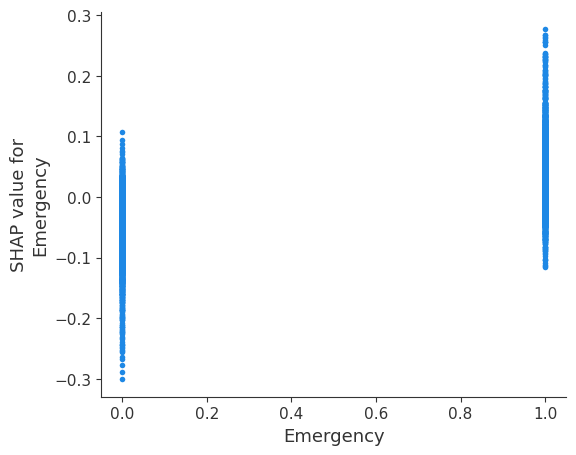

In [26]:
for x in X.columns: shap.dependence_plot(x, shap_values, X_test, interaction_index=None)